In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import clear_output

In [39]:
np.random.seed(42)

In [40]:
DTYPE = np.float32

In [ ]:
path = r'\Deep-Learning\datasets\chineseMNIST.csv'

In [42]:
df = pd.read_csv(path)

In [43]:
def one_hot(data, num_classes):
    new_data = np.zeros((data.shape[0], num_classes))
    new_data[np.arange(data.shape[0]), data] = 1
    return new_data

In [44]:
def shuffle(x, y=None):
    KEYS = np.arange(x.shape[0])
    np.random.shuffle(KEYS)
    x = x[KEYS]

    if y is not None:
        y = y[KEYS]
        return x, y
    
    return x

In [45]:
def split_data(x, y=None, split=0.2):
    x_test, x_train = x[:int(x.shape[0]*split)], x[int(x.shape[0]*split):]
    
    if y is not None:
        y_test, y_train = y[:int(y.shape[0]*split)], y[int(y.shape[0]*split):]
        return x_train, y_train, x_test, y_test
    
    return x_train, x_test

In [46]:
def print_shapes(*data):
    for d in data:
        print(d.shape)

In [47]:
df['label'].replace(100,11,inplace=True)
df['label'].replace(1000,12,inplace=True)
df['label'].replace(10000,13,inplace=True)
df['label'].replace(100000000,14,inplace=True)
clear_output()

In [48]:
x = df.iloc[:, :-2]
y = df.iloc[:, -2]
simbols = df.iloc[:, -1]

x, y = np.array(x).astype(DTYPE), np.array(y)

In [49]:
table = dict(set((label, simbol) for label, simbol in zip(y, simbols)))

In [50]:
y = one_hot(y, len(table)).astype(DTYPE)
x = x / 255.0

In [51]:
x, y = shuffle(x, y)

In [52]:
x_train, y_train, x_test, y_test = split_data(x, y, split=0.2)

In [53]:
print_shapes(x_train, y_train, x_test, y_test)

(12000, 4096)
(12000, 15)
(3000, 4096)
(3000, 15)


八


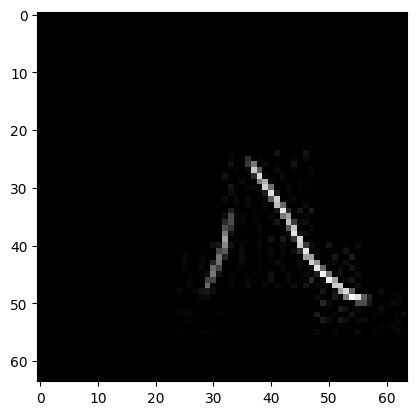

In [54]:
random_idx = np.random.randint(0, x_train.shape[0])
random_simbol = table[np.argmax(y_train[random_idx])]
random_image = x_train[random_idx]
print(random_simbol)
plt.imshow(random_image.reshape(64, 64), cmap='gray')
plt.show()

In [55]:
def ReLU(x, derv=False):
    if derv: return np.where(x>0, 1, 0)
    return np.maximum(x, 0)

In [56]:
def softmax(x, derv=False):
    x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    s = x_exp / np.sum(x_exp, axis=1, keepdims=True)
    if derv: return s * (1 - s)
    return s

In [57]:
def CCE(y_true, y_pred, epsilon=1e-8, derv=False):
    if derv: return y_pred - y_true # CCE + softmax
    return -np.sum(y_true*np.log(y_pred + epsilon))

In [58]:
def CategoricalAccuracy(y_true, y_pred):
    return np.sum(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

In [59]:
n_INPUTS = x_train.shape[1]
hidden_1 = 128
hidden_2 = 64
n_OUTPUTS = y_train.shape[1]

In [60]:
W0 = np.random.randn(n_INPUTS, hidden_1).astype(DTYPE) * np.sqrt(2/n_INPUTS)
b0 = np.zeros((1, hidden_1)).astype(DTYPE)

W1 = np.random.randn(hidden_1, hidden_2).astype(DTYPE) * np.sqrt(2/hidden_1)
b1 = np.zeros((1, hidden_2)).astype(DTYPE)

W2 = np.random.randn(hidden_2, n_OUTPUTS).astype(DTYPE) * np.sqrt(2/hidden_2)
b2 = np.zeros((1, n_OUTPUTS)).astype(DTYPE)

params = [W0, b0, W1, b1, W2, b2]
len_params = len(params)

In [61]:
# Adam settings
lr = 0.001
current_lr = lr
decay = 0
beta_1 = 0.9
beta_2 = 0.999
t = 1
m = [0] * len_params
v = [0] * len_params
epsilon_adam = 1e-8

In [62]:
def prev_update():
    global current_lr
    if decay:
        current_lr = lr * (1 / (1 + decay * t))

In [63]:
def step():
    global t
    t += 1

In [64]:
def optimizer_adam(grads, i):
    m[i] = beta_1 * m[i] + (1 - beta_1) * grads
    v[i] = beta_2 * v[i] + (1 - beta_2) * grads**2
    m_h = m[i] / (1 - beta_1**t)
    v_h = v[i] / (1 - beta_2**t)
    return m_h / (np.sqrt(v_h) + epsilon_adam)

In [65]:
def update_params(grads):
    prev_update()
    for i in range(len_params):
        params[i] -= current_lr * optimizer_adam(grads[i], i)
    step()

In [66]:
def forward(x):
    global z0, z1, z2, a0, a1, a2

    z0 = x @ W0 + b0
    a0 = ReLU(z0)

    z1 = a0 @ W1 + b1
    a1 = ReLU(z1)

    z2 = a1 @ W2 + b2
    a2 = softmax(z2)

    return a2

In [67]:
def backward(x=None, y=None, outp=None, dout=None, learn=True):
    if y is not None:
        dL = CCE(y, outp, derv=True)
    elif dout is not None:
        dL = dout
    else: raise ValueError('there is no (y) or (dout).')
    m = dL.shape[0]
    # dL *= softmax(z2, derv=True) # Comented cuz CCE alr implements CCE + softmax

    dW2 = a1.T @ dL / m
    db2 = dL.sum(axis=0, keepdims=True) / m

    da1 = dL @ W2.T
    dz1 = da1 * ReLU(z1, derv=True)

    dW1 = a0.T @ dz1 / m
    db1 = dz1.sum(axis=0, keepdims=True) / m

    da0 = dz1 @ W1.T
    dz0 = da0 * ReLU(z0, derv=True)

    dW0 = x.T @ dz0 / m
    db0 = dz0.sum(axis=0, keepdims=True) / m

    gradients = dW0, db0, dW1, db1, dW2, db2

    dout = dz0 @ W0.T

    if learn:
        update_params(gradients)

    return dout, gradients


In [68]:
def train(x, y, epochs=10, batch_size=32, shuffle_data=True, verbose=True, print_every=0.1, x_test=None, y_test=None):

    history_loss, history_acc = [], []

    for ep in range(1, epochs+1):
        
        if shuffle_data:
            x, y = shuffle(x, y)

        loss_ep = 0.0
        acc_ep = 0.0
        start = time.time()

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            predictions = forward(x_batch)
            loss_ep += CCE(y_batch, predictions)
            acc_ep += CategoricalAccuracy(y_batch, predictions)
            backward(x_batch, y_batch, predictions, learn=True)
            print(f'EPOCH: {ep}, batch: [{i//batch_size+1}/{x.shape[0]//batch_size+1}]', end='\r')
        
        avg_loss = loss_ep / x.shape[0]
        avg_acc = acc_ep / x.shape[0]
        avg_time = time.time()-start

        history_loss.append(avg_loss)
        history_acc.append(avg_acc)

        if verbose and ep % max(1, int(epochs*print_every)) == 0:
            message = f'Epoch: [{ep}/{epochs}] time: {avg_time:.2f} seconds > Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}'

            if x_test is not None and y_test is not None:

                loss_test = 0.0
                acc_test = 0.0

                for i in range(0, x_test.shape[0], batch_size):
                    x_batch = x_test[i:i+batch_size]
                    y_batch = y_test[i:i+batch_size]

                    predictions = forward(x_batch)
                    loss_test += CCE(y_batch, predictions)
                    acc_test += CategoricalAccuracy(y_batch, predictions)
                
                avg_loss_test = loss_test / x_test.shape[0]
                avg_acc_test = acc_test / x_test.shape[0]

                message += f', Test Loss: {avg_loss_test:.4f}, Test Acc: {avg_acc_test:.4f}'
            
            print(message)

    return history_loss, history_acc

In [69]:
history_loss, history_acc = train(
    x=x_train,
    y=y_train,
    epochs=10,
    batch_size=32,
    shuffle_data=True,
    verbose=True,
    print_every=0.1,
    x_test=x_test,
    y_test=y_test
)

Epoch: [1/10] time: 15.16 seconds > Loss: 1.7581, Acc: 0.4648, Test Loss: 1.2297, Test Acc: 0.6200
Epoch: [2/10] time: 14.92 seconds > Loss: 0.8531, Acc: 0.7411, Test Loss: 0.8163, Test Acc: 0.7407
Epoch: [3/10] time: 15.24 seconds > Loss: 0.5117, Acc: 0.8476, Test Loss: 0.6758, Test Acc: 0.7763
Epoch: [4/10] time: 12.90 seconds > Loss: 0.3399, Acc: 0.8990, Test Loss: 0.6142, Test Acc: 0.8020
Epoch: [5/10] time: 14.67 seconds > Loss: 0.2336, Acc: 0.9346, Test Loss: 0.6092, Test Acc: 0.7990
Epoch: [6/10] time: 16.21 seconds > Loss: 0.1627, Acc: 0.9565, Test Loss: 0.5891, Test Acc: 0.8110
Epoch: [7/10] time: 14.47 seconds > Loss: 0.1162, Acc: 0.9718, Test Loss: 0.6214, Test Acc: 0.8097
Epoch: [8/10] time: 13.45 seconds > Loss: 0.0846, Acc: 0.9825, Test Loss: 0.6350, Test Acc: 0.8170
Epoch: [9/10] time: 13.11 seconds > Loss: 0.0634, Acc: 0.9870, Test Loss: 0.6488, Test Acc: 0.8153
Epoch: [10/10] time: 13.37 seconds > Loss: 0.0435, Acc: 0.9929, Test Loss: 0.6602, Test Acc: 0.8220


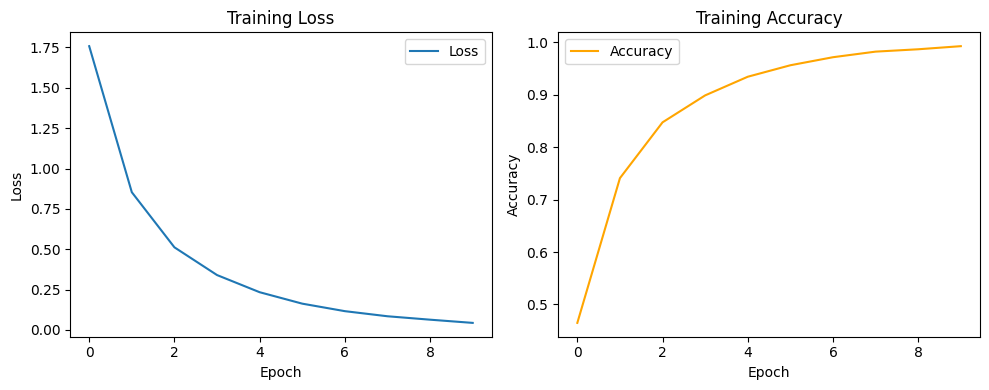

In [70]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_loss, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_acc, label='Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
def get_accuracy(x, y):
    loss = 0.0
    acc = 0.0

    for i in range(0, x.shape[0], 64):
        x_batch = x[i:i+64]
        y_batch = y[i:i+64]

        predictions = forward(x_batch)
        loss += CCE(y_batch, predictions)
        acc += CategoricalAccuracy(y_batch, predictions)
                
    avg_loss = loss / x.shape[0]
    avg_acc = acc / x.shape[0]
    return avg_loss, avg_acc

In [72]:
def predict_random_character():
    random_idx = np.random.randint(0, x_test.shape[0])
    random_simbol = table[np.argmax(y_test[random_idx])]
    random_image = x_test[random_idx:random_idx+1]
    model_prediction = forward(random_image)
    model_simbol = table[np.argmax(model_prediction)]
    print(f'Real Simbol: {random_simbol} | Model_predict: {model_simbol}')
    plt.imshow(random_image.reshape(64, 64), cmap='gray')
    plt.show()


In [73]:
final_loss, final_acc = get_accuracy(x_test, y_test)

In [74]:
print(f'Final Loss: {final_loss:.4f} | Final Accuracy: {final_acc:.2%}')

Final Loss: 0.6602 | Final Accuracy: 82.20%


### Final Accuracy: 81~83%

Real Simbol: 九 | Model_predict: 九


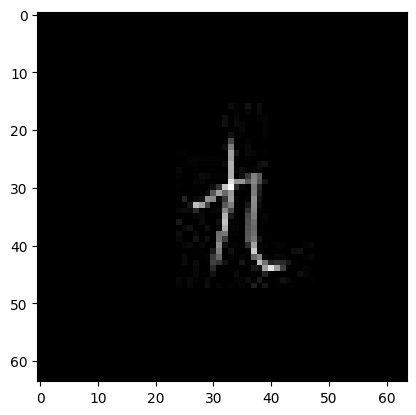

In [77]:
predict_random_character()